## Browse DKRZ catalog on Levante HPC system

Search for LUMIP simulations and available models

In [1]:
import os
import glob
import netCDF4 as nc

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import seaborn as sns

import numpy as np
import xarray as xr
import cftime
import pandas as pd

# Regridding
# import xesmf as xe


In [2]:
data_path = "G:/My Drive/MPIM/data/"

## Functions

In [3]:
def xr_fix_time(xr_in, date_start, date_end):
    
    if xr_in['time'].dt.calendar == 'noleap' or xr_in['time'].dt.calendar == '360_day':
        xr_in = xr_in.convert_calendar(calendar = 'gregorian', align_on = 'date')
        
    else: None
    
    time = pd.date_range(start=date_start, end=date_end, freq='M').to_numpy(dtype='datetime64[ns]')
    xr_out = xr_in.assign_coords(time = time)
    
    return xr_out

In [4]:
def xr_clean(xr_in, dims):
    data = xr_in.copy()
    for i,d in enumerate(dims):
        if d in data.coords and d in data.dims:
            data = data.drop(d)
            data = data.isel({d : 0})
        if d in data.coords:
            data = data.drop(d)
        if d in data.dims and d not in data.coords:
            data = data.isel({d : 0})
        if data.attrs == {}:
            None
        else:
            if d in data.data_vars:
                data = data.drop_vars(d)
    xr_out = data
    return xr_out

In [5]:
def lon180(ds):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    return ds

In [6]:
def xr_multimodel_sign(xr_in, models):
    # Computes the Multimodel MEAN and STD
    # xr_in: list of xarray models
    mm = xr.concat(xr_in, dim = "esm", coords = "minimal", compat = "override")
    
    std = xr.concat(xr_in, dim = "esm", coords = "minimal", compat = "override").std(dim = "esm")
    
    # Multimodel agreement in the sign of the sensitivity
    sign = xr.where(mm > 0, 1, -1)
    agreement = (np.abs(sign.sum(dim = "esm")/len(models)))
    
    mean = mm.mean(dim = "esm")
    return (mean, std, agreement)

In [7]:
def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

In [8]:
def detrend_dim(da, dim, degree):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = (da - fit)
    return da_det

In [9]:
#### --------- Mann-Whitney Test --------- ####
from scipy.stats import mannwhitneyu

# Test applied on a grid-cell basis. For every gid-cell, the statistical difference between two time series is computed.
# 1st time series: Nino years' (DS_models_hist_nino)
# 2nd time series: Reference climatology (DS_models_hist_clim or DS_models_hist_clim_neutral)  

## -- Function for grid-cell operations -- ##
def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    """
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = np.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = np.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return np.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)


def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [10]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    results = {}
    results["cor"] = cor
    results["coef"] = slope
    results["pval"] = pval
    return results

## Import preprocessed data

In [11]:
models = ["ACCESS-ESM1-5", "CanESM5", "IPSL-CM6A-LR", "MPI-ESM1-2-LR", "UKESM1-0-LL"]

In [12]:
scenario = 'ssp126Lu'
xr_aff = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_aff.append(content)


scenario = 'ssp370'
xr_ctl = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_ctl.append(content)


In [13]:
scenario = 'ssp126Lu'
xr_aff_pft = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '_pft.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_aff_pft.append(content)


scenario = 'ssp370'
xr_ctl_pft = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '_pft.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_ctl_pft.append(content)


Preprocessing

In [14]:
# Convert pr and evspsbl from kg m-2 s-1 to mm month-1
for i,mm in enumerate(models):
    xr_ctl[i]["pr"] = xr_ctl[i].pr*86400* xr_ctl[i].time.dt.days_in_month
    xr_aff[i]["pr"] = xr_aff[i].pr*86400* xr_aff[i].time.dt.days_in_month
    
    xr_ctl[i]["pr"].attrs=dict(units="mm/months")
    xr_aff[i]["pr"].attrs=dict(units="mm/months")

    xr_ctl[i]["evspsbl"] = xr_ctl[i].evspsbl*86400* xr_ctl[i].time.dt.days_in_month
    xr_aff[i]["evspsbl"] = xr_aff[i].evspsbl*86400* xr_aff[i].time.dt.days_in_month
    
    xr_ctl[i]["evspsbl"].attrs=dict(units="mm/months")
    xr_aff[i]["evspsbl"].attrs=dict(units="mm/months")

#### PET estimation according to Priestley-Taylor 

In [15]:
Cp = 1.0051*10**(-3)   # Specific heat of air at constant pressure (C_p)in MJ/(kg K)
Lv = 2.45              # Latent Heat of Vaporization for Water.  FAO uses constant 2.45 MJ/kg


In [16]:
def PriestleyTaylor(xr, alpha=1.26):
    # From https://www.nature.com/articles/s41597-023-02290-0
    '''Calculate Priestley-Taylor potential evapotranspiration for the given dictionary of input files'''
    
    # Convert to Celsius if temperature is in Kelvin
    # if xr['ts'].attrs['units'] == 'K':
    ts=xr['ts']-273.15

    # Net radiation = H + LE
    Rn = xr.hfss + xr.hfls
    
    # Psychometric constant
    psy = Cp*xr.ps/(1000*Lv*.622)                             # kPa
    
    # Saturation Vapour Pressure
    sat = (0.61078**(17.27*(ts)/(ts+237.3)))            # kPa
    
    # Delta
    delta = 4098*sat/((ts+237.3)**2)                     # kPa/K
    
    # Calculate PET using the Priestley-Taylor formulation with constant alpha (defalut alpha = 1.26)
    xr['pet'] = (alpha*delta*Rn)/(Lv*(delta+psy))             # mm/month

    # Mask out the ocean
    mask = np.ma.masked_equal(xr.lai, np.nan) 
    xr['pet'] = xr['pet'] * mask

    # Define variable attributes
    xr['pet'].attrs['units'] = 'mm month-1'
    xr['pet'].attrs['short_name'] = 'PET'
    xr['pet'].attrs['long_name'] = 'Priestley-Taylor Potential Evapotranspriation'
    xr['pet'].attrs['description'] = 'Priestley-Taylor Potential Evapotranspiration computed using formulation described in Priestley & Taylor (1972) with alpha = '+str(alpha)
    
    # # Aridity Index
    # xr['ai'] = xr['pet']*xr['pr']**-1
    # xr['ai'].attrs['units'] = 'mm month-1'
    # xr['ai'].attrs['short_name'] = 'AI'
    # xr['ai'].attrs['long_name'] = 'Aridity Index'
    # xr['ai'].attrs['description'] = 'PET/P'
      
    return xr

In [17]:
for i, mm in enumerate(models):
    PriestleyTaylor(xr_ctl[i], alpha=1.26)
    PriestleyTaylor(xr_aff[i], alpha=1.26) 

In [18]:
xr_delta = []
xr_delta_pft = []
for i,mm in enumerate(models):
    xr_delta.append(xr_aff[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") - xr_ctl[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time"))
    xr_delta_pft.append(xr_aff_pft[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") - xr_ctl_pft[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time"))

#### Water-Energy limitation

In [19]:
def regime_limit(dataset):
    # Definition of water-limited regions as from Forzieri et al., (2020) (https://www.nature.com/articles/s41558-020-0717-0)
    # Water-limited: cor(le,pr) > cor(le,ts) and vice-versa for Energy-limited regions
    cor_pr = lag_linregress_3D(dataset['hfls'], dataset['pr'])['cor'].compute()
    cor_ts = lag_linregress_3D(dataset['hfls'], dataset['ts'])['cor'].compute()
    
    water_limited = dataset.isel(time = -1).where(cor_pr > cor_ts, drop=True)["lai"]
    energy_limited = dataset.isel(time = -1).where(cor_pr < cor_ts, drop=True)["lai"]
    
    # Ensure computation and time slice selection
    return water_limited, energy_limited

In [20]:
mask_aff_water = []
mask_aff_energy = []
mask_ctl_water = []
mask_ctl_energy = []
for i, mm in enumerate(models):
    water, energy = regime_limit(xr_aff[i])
    mask_aff_water.append(water)
    mask_aff_energy.append(energy)
    
    water, energy = regime_limit(xr_ctl[i])
    mask_ctl_water.append(water)
    mask_ctl_energy.append(energy)

### Mask treeFrac

In [21]:
%%capture

dtree = []

# masking regions of treefrac increase or decrease
mask_treefrac_pos = []
mask_treefrac_neg = []

for m,_ in enumerate(models):
    
    # identify regions with 5%+ and 5%- treefrac
    mask_treefrac_pos.append(xr_delta_pft[m]["treeFrac"].where(xr_delta_pft[m]["treeFrac"] > 10))
    mask_treefrac_neg.append(xr_delta_pft[m]["treeFrac"].where(xr_delta_pft[m]["treeFrac"] <- 10))


## Multilinear Regression

In [135]:
# Save and export regression list data
import pickle

with open(os.path.join(data_path+"ols_reg_coef_LE"), "rb") as fp:   #Pickling
    coef_reg_LE = pickle.load(fp)

with open(os.path.join(data_path+"ols_reg_pval_LE"), "rb") as fp:   #Pickling
    pval_reg_LE = pickle.load(fp)

with open(os.path.join(data_path+"ols_reg_r2_LE"), "rb") as fp:   #Pickling
    r2_reg_LE = pickle.load(fp)

with open(os.path.join(data_path+"ols_reg_ypred_LE"), "rb") as fp:   #Pickling
    ypred_reg_LE = pickle.load(fp)

In [136]:
# Save and export regression list data
import pickle

with open(os.path.join(data_path+"ols_reg_coef_H"), "rb") as fp:   #Pickling
    coef_reg_H = pickle.load(fp)

with open(os.path.join(data_path+"ols_reg_pval_H"), "rb") as fp:   #Pickling
    pval_reg_H = pickle.load(fp)

with open(os.path.join(data_path+"ols_reg_r2_H"), "rb") as fp:   #Pickling
    r2_reg_H = pickle.load(fp)

with open(os.path.join(data_path+"ols_reg_ypred_H"), "rb") as fp:   #Pickling
    ypred_reg_H = pickle.load(fp)

### Masking water & energy limited regions

In [137]:
coef_pos_water = []
coef_pos_energy = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    content = (coef_reg_LE[m].where(mask_treefrac_pos[m].notnull()).where(mask_aff_water[m].notnull())
                              .stack(cell=["lon", "lat"])).dropna(dim='cell').to_dataframe(name = "reg_coef").drop(columns = ["lon", "lat","height", "reg_coef"]) #.dropna()
    content1 = (coef_reg_LE[m].where(mask_treefrac_pos[m].notnull()).where(mask_aff_energy[m].notnull())
                              .stack(cell=["lon", "lat"])).dropna(dim='cell').to_dataframe(name = "reg_coef").drop(columns = ["lon", "lat","height","reg_coef"]) #.dropna()
    if hasattr(content, "type"):
        content = content.drop(columns = ["type"])
        content1 = content1.drop(columns = ["type"])
    if hasattr(content, "time"):
        content = content.drop(columns = ["time"])
        content1 = content1.drop(columns = ["time"])
    coef_pos_water.append(content.reset_index())
    coef_pos_energy.append(content1.reset_index())
    
    # coef_pos_water[m]['coef'] = coef_pos_water[m]['coef'].map(mapping)
    # coef_pos_energy[m]['coef'] = coef_pos_energy[m]['coef'].map(mapping)

coef_pos_LE = []
for m,mm in enumerate(models):
    a = pd.melt(coef_pos_water[m].drop(columns = ["lon", "lat"])); a["regime"] = "water-lim"
    b = pd.melt(coef_pos_energy[m].drop(columns = ["lon", "lat"])); b["regime"] = "energy-lim"
    coef_pos_LE.append(pd.concat([a,b], axis = 0))
del a, b

In [138]:
coef_pos_water = []
coef_pos_energy = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    content = (coef_reg_LE[m].where(mask_treefrac_pos[m].notnull()).where(mask_aff_water[m].notnull())
                              .stack(cell=["lon", "lat"])).dropna(dim='cell').to_dataframe(name = "reg_coef").drop(columns = ["lon", "lat","height", "reg_coef"]) #.dropna()
    content1 = (coef_reg_LE[m].where(mask_treefrac_pos[m].notnull()).where(mask_aff_energy[m].notnull())
                              .stack(cell=["lon", "lat"])).dropna(dim='cell').to_dataframe(name = "reg_coef").drop(columns = ["lon", "lat","height","reg_coef"]) #.dropna()
    if hasattr(content, "type"):
        content = content.drop(columns = ["type"])
        content1 = content1.drop(columns = ["type"])
    if hasattr(content, "time"):
        content = content.drop(columns = ["time"])
        content1 = content1.drop(columns = ["time"])
    coef_pos_water.append(content.reset_index())
    coef_pos_energy.append(content1.reset_index())
    
    # coef_pos_water[m]['coef'] = coef_pos_water[m]['coef'].map(mapping)
    # coef_pos_energy[m]['coef'] = coef_pos_energy[m]['coef'].map(mapping)

coef_pos_H = []
for m,mm in enumerate(models):
    a = pd.melt(coef_pos_water[m].drop(columns = ["lon", "lat"])); a["regime"] = "water-lim"
    b = pd.melt(coef_pos_energy[m].drop(columns = ["lon", "lat"])); b["regime"] = "energy-lim"
    coef_pos_H.append(pd.concat([a,b], axis = 0))
del a, b

### dLE/dtreeFrac

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04



ValueError: box_pairs contains an invalid box pair.

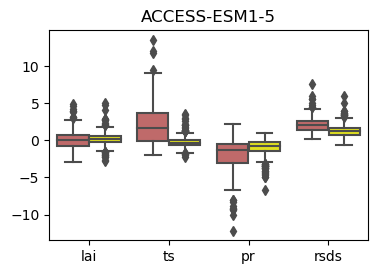

In [139]:
from statannot import add_stat_annotation
import seaborn.categorical


width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)
    
for m, mm in enumerate(models):
    df = coef_pos[m]
    
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
        axs = sns.boxplot(data=df, x='variable', y='value', hue='regime', palette=['indianred', 'yellow'])

        # axs.set_xticklabels(regions, rotation = 75)
        # axs.set_ylim(-1, 1)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    else:
        axs = fig.add_subplot(gs[1, m-3])
        axs = sns.boxplot(data=df, x='variable', y='value', hue='regime', palette=['indianred', 'yellow'])

        # axs.set_xticklabels(regions, rotation = 75)
        # axs.set_ylim(-1, 1)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)
    
    
    add_stat_annotation(axs, data=df, x='variable', y='value', hue='regime',
                    box_pairs=[(("treeFrac", "water-lim"), ("treeFrac", "energy-lim"))],
                    test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = "bonferroni", verbose=2)

# fig.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
fig.suptitle("Multilinear regression (dLE/dX)", y =1.05, x = 0.45)


### dLE/dLAI

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

lai_water-lim v.s. lai_energy-lim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.702e-15 U_stat=4.507e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

lai_water-lim v.s. lai_energy-lim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.550e-03 U_stat=1.901e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

lai_water-lim v.s. lai_energy-lim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.905e-47 U_stat=4.793e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e

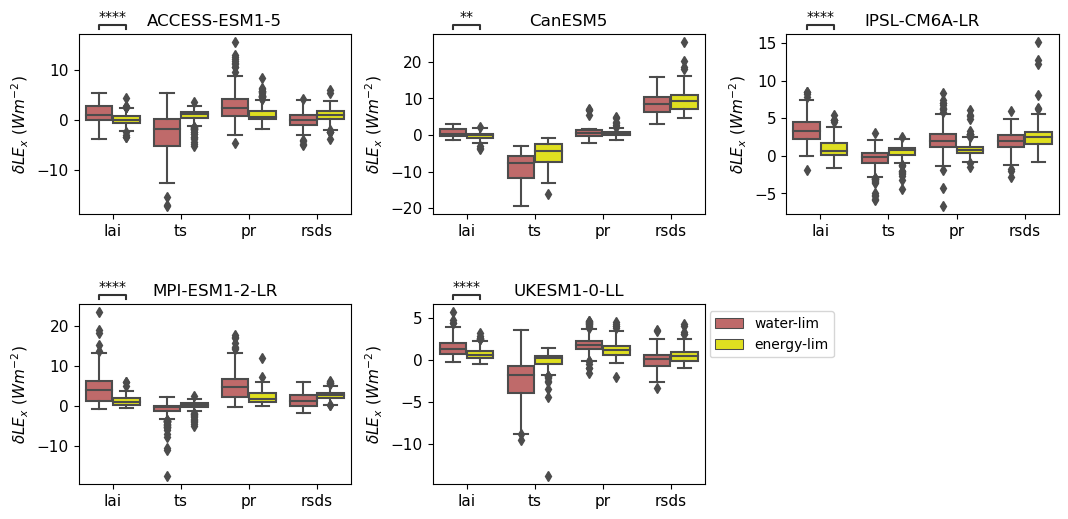

In [140]:
from statannot import add_stat_annotation
import seaborn.categorical


width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)
    
for m, mm in enumerate(models):
    df = coef_pos_LE[m]
    
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
    else:
        axs = fig.add_subplot(gs[1, m-3])

    axs = sns.boxplot(data=df, x='variable', y='value', hue='regime', palette=['indianred', 'yellow'])

    # axs.set_xticklabels(regions, rotation = 75)
    # axs.set_ylim(-1, 1)
    # axs.legend(loc='upper right', fontsize = 10)
    axs.legend_.remove()
    axs.set_xlabel("")
    axs.tick_params(labelsize=11)
    axs.set_ylabel("$\delta LE_{x}$ $(W m^{-2})$", fontsize = 11)
    axs.set_title(models[m])
    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)
    
    
    add_stat_annotation(axs, data=df, x='variable', y='value', hue='regime',
                    box_pairs=[(("lai", "water-lim"), ("lai", "energy-lim"))],
                    test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = "bonferroni", verbose=2)

# fig.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
# fig.suptitle("Multilinear regression (dLE/dX)", y =1.05, x = 0.45)


### dH/dLAI

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

lai_water-lim v.s. lai_energy-lim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.786e-01 U_stat=2.963e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

lai_water-lim v.s. lai_energy-lim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.329e-01 U_stat=1.240e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

lai_water-lim v.s. lai_energy-lim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.191e-31 U_stat=1.014e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e

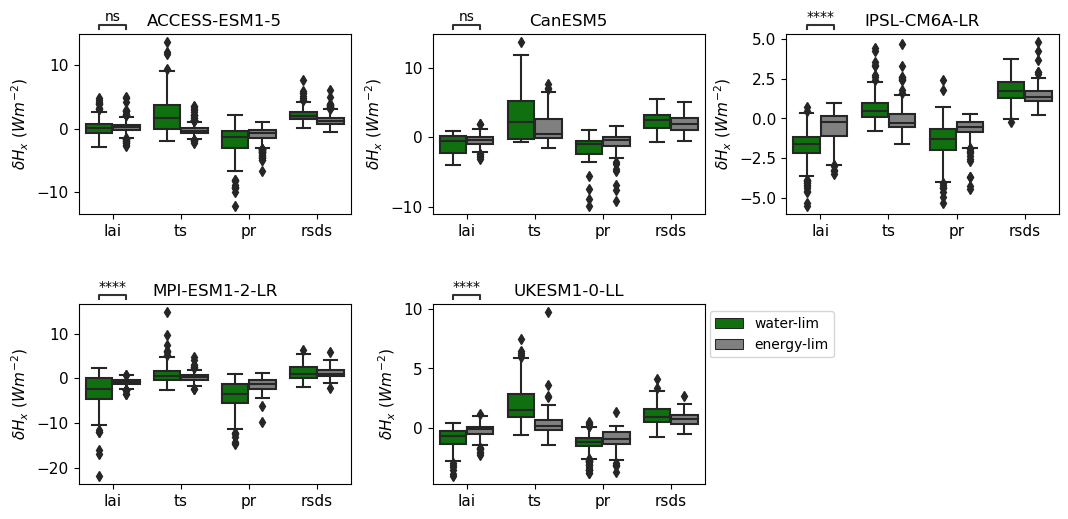

In [61]:
from statannot import add_stat_annotation
import seaborn.categorical


width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)
    
for m, mm in enumerate(models):
    df = coef_pos_H[m]
    
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
    else:
        axs = fig.add_subplot(gs[1, m-3])

    axs = sns.boxplot(data=df, x='variable', y='value', hue='regime', palette=['green', 'grey'])

    # axs.set_xticklabels(regions, rotation = 75)
    # axs.set_ylim(-1, 1)
    # axs.legend(loc='upper right', fontsize = 10)
    axs.legend_.remove()
    axs.set_xlabel("")
    axs.tick_params(labelsize=11)
    axs.set_ylabel("$\delta H_{x}$ $(W m^{-2})$", fontsize = 11)
    axs.set_title(models[m])

    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)
    
    
    add_stat_annotation(axs, data=df, x='variable', y='value', hue='regime',
                    box_pairs=[(("lai", "water-lim"), ("lai", "energy-lim"))],
                    test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = "bonferroni", verbose=2)

# fig.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
# fig.suptitle("Multilinear regression (dLE/dX)", y =1.05, x = 0.45)


## Water Availability effect of afforestation

### Soil Moisture

In [21]:
mrso_pos_water_mean = []
mrso_pos_energy_mean = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    mask = mask_treefrac_pos[m].notnull() & mask_aff_water[m].notnull()
    mask1 = mask_treefrac_pos[m].notnull() & mask_aff_energy[m].notnull()

    data = ((xr_aff[m].sel(time=slice("2071-01", "2100-12")).mean(dim = "time").mrso) - 
            (xr_ctl[m].sel(time=slice("2071-01", "2100-12")).mean(dim = "time").mrso))

    # data = ((xr_aff[m].sel(time=slice("2071-01", "2100-12")).mean(dim = "time").pr - xr_aff[m].sel(time=slice("2071-01", "2100-12")).mean(dim = "time").evspsbl) - 
    #         (xr_ctl[m].sel(time=slice("2071-01", "2100-12")).mean(dim = "time").pr - xr_ctl[m].sel(time=slice("2071-01", "2100-12")).mean(dim = "time").evspsbl))

    masked = data.where(mask)
    masked1 = data.where(mask1)
    content = masked.weighted(cell_weight(masked)).mean(["lat","lon"]).data
    content1 = masked1.weighted(cell_weight(masked1)).mean(["lat","lon"]).data
    content = np.array(content)
    content1 = np.array(content1)
    mrso_pos_water_mean.append(content); 
    mrso_pos_energy_mean.append(content1);
    
mrso_pos_water_mean = pd.DataFrame(mrso_pos_water_mean, index = models)
mrso_pos_energy_mean = pd.DataFrame(mrso_pos_energy_mean, index = models)

mrso_pos_water_mean = pd.melt(mrso_pos_water_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")
mrso_pos_water_mean["regime"] = "water-lim"

mrso_pos_energy_mean = pd.melt(mrso_pos_energy_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")
mrso_pos_energy_mean["regime"] = "energy-lim"

mrso_regime = pd.concat([mrso_pos_water_mean, mrso_pos_energy_mean], axis = 0)
mrso_regime = mrso_regime.drop(columns = "variable")

Text(0.5, 1.0, 'Water availability')

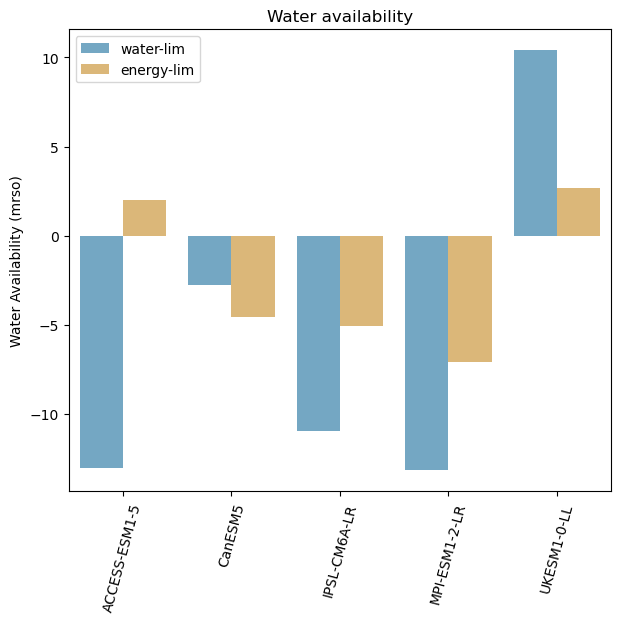

In [23]:
import seaborn as sns

fig = plt.figure(figsize=(7, 6))

ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=mrso_regime, hue = "regime",# errorbar=("pi", 50),
        x="models", y="value",
        palette="colorblind", alpha=.6, 
    )
ax0.set_xticklabels(models, rotation = 75)
# ax0.set_ylim(-0.35, 0.35)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("Water Availability (mrso)")
ax0.set_title("Water availability")



### P-ET

In [28]:
wa_pos_water_mean = []
wa_pos_energy_mean = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    mask = mask_treefrac_pos[m].notnull() & mask_aff_water[m].notnull()
    mask1 = mask_treefrac_pos[m].notnull() & mask_aff_energy[m].notnull()

    data = ((xr_aff[m].sel(time=slice("2071-01", "2100-12")).mean(dim = "time").pr - xr_aff[m].sel(time=slice("2071-01", "2100-12")).mean(dim = "time").evspsbl) - 
            (xr_ctl[m].sel(time=slice("2071-01", "2100-12")).mean(dim = "time").pr - xr_ctl[m].sel(time=slice("2071-01", "2100-12")).mean(dim = "time").evspsbl))

    masked = data.where(mask)
    masked1 = data.where(mask1)
    content = masked.weighted(cell_weight(masked)).mean(["lat","lon"]).data
    content1 = masked1.weighted(cell_weight(masked1)).mean(["lat","lon"]).data
    content = np.array(content)
    content1 = np.array(content1)
    wa_pos_water_mean.append(content); 
    wa_pos_energy_mean.append(content1);
    
wa_pos_water_mean = pd.DataFrame(wa_pos_water_mean, index = models)
wa_pos_energy_mean = pd.DataFrame(wa_pos_energy_mean, index = models)

wa_pos_water_mean = pd.melt(wa_pos_water_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")
wa_pos_water_mean["regime"] = "water-lim"

wa_pos_energy_mean = pd.melt(wa_pos_energy_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")
wa_pos_energy_mean["regime"] = "energy-lim"

wa_regime = pd.concat([wa_pos_water_mean, wa_pos_energy_mean], axis = 0)
wa_regime = wa_regime.drop(columns = "variable")

Text(0.5, 1.0, 'Water availability (P-ET)')

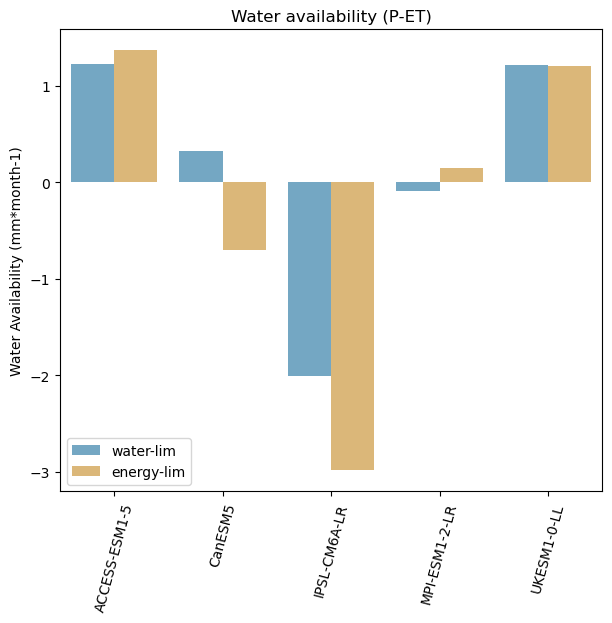

In [32]:
import seaborn as sns

fig = plt.figure(figsize=(7, 6))

ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=wa_regime, hue = "regime",# errorbar=("pi", 50),
        x="models", y="value",
        palette="colorblind", alpha=.6, 
    )
ax0.set_xticklabels(models, rotation = 75)
# ax0.set_ylim(-0.35, 0.35)
ax0.legend(loc='lower left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("Water Availability (mm*month-1)")
ax0.set_title("Water availability (P-ET)")


### Aridity Index De Martonne (T/P+10)

In [24]:
xr_delta_y = list()
# xr_delta_pft_y = list()
for m,mm in enumerate(models):
    content = (xr_aff[m] - xr_ctl[m]).copy()
    pr = content["pr"].resample(time='Y', label='left').mean().compute()
    content = content.resample(time='Y', label='left').mean().compute()
    content["pr"] = pr

    # content1 = (xr_aff_pft[m] - xr_ctl_pft[m]).copy()
    # content1 = content1.resample(time='Y', label='left').mean().compute()
    
    # xr_delta_y.append(xr.merge([content,content1]))
    xr_delta_y.append(content)
    
del content
# del content1

In [25]:
aidm_pos_water_mean = []
aidm_pos_energy_mean = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    mask = mask_treefrac_pos[m].notnull() & mask_aff_water[m].notnull()
    mask1 = mask_treefrac_pos[m].notnull() & mask_aff_energy[m].notnull()

    data = (xr_delta_y[m].sel(time=slice("2071-01", "2100-12")).mean(dim = "time").pr / (xr_delta_y[m].sel(time=slice("2071-01", "2100-12")).mean(dim = "time").ts + 10))

    masked = data.where(mask)
    masked1 = data.where(mask1)
    content = masked.weighted(cell_weight(masked)).mean(["lat","lon"]).data
    content1 = masked1.weighted(cell_weight(masked1)).mean(["lat","lon"]).data
    content = np.array(content)
    content1 = np.array(content1)
    aidm_pos_water_mean.append(content); 
    aidm_pos_energy_mean.append(content1);
    
aidm_pos_water_mean = pd.DataFrame(aidm_pos_water_mean, index = models)
aidm_pos_energy_mean = pd.DataFrame(aidm_pos_energy_mean, index = models)

aidm_pos_water_mean = pd.melt(aidm_pos_water_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")
aidm_pos_water_mean["regime"] = "water-lim"

aidm_pos_energy_mean = pd.melt(aidm_pos_energy_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")
aidm_pos_energy_mean["regime"] = "energy-lim"

aidm_regime = pd.concat([aidm_pos_water_mean, aidm_pos_energy_mean], axis = 0)
aidm_regime = aidm_regime.drop(columns = "variable")

Text(0.5, 1.0, 'Aridity Index De Martonne ')

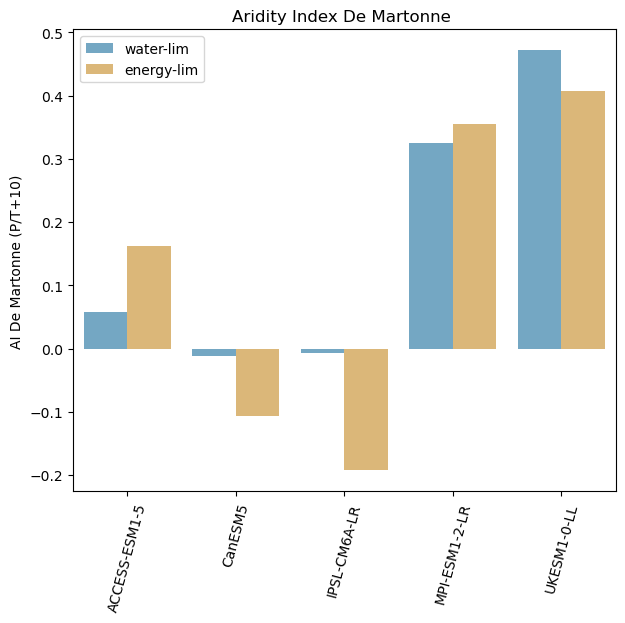

In [26]:
import seaborn as sns

fig = plt.figure(figsize=(7, 6))

ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=aidm_regime, hue = "regime",# errorbar=("pi", 50),
        x="models", y="value",
        palette="colorblind", alpha=.6, 
    )
ax0.set_xticklabels(models, rotation = 75)
# ax0.set_ylim(-0.35, 0.35)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("AI De Martonne (P/T+10)")
ax0.set_title("Aridity Index De Martonne ")



### dSM/dLAI

In [183]:
%%capture

from sklearn import linear_model
from regressors import stats

linear = linear_model.LinearRegression()
# linear = linear_model.Ridge()

dSM_dLAI = []
dSM_dLAI_pval = []

for m, mm in enumerate(models):
    data = (xr_aff[m] - xr_ctl[m])
    lai = (xr_aff[m].lai - xr_ctl[m].lai)
    ## Preprocessing
    # Dimension time on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. 
    # To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.compute()`
    # Replace NaN and 0 with 0.01 to avoid Singular Matrix 

    # X1 = data.lai.resample(time='Y', label='left').mean().compute()

    X = data.mrso.resample(time='Y', label='left').mean().compute()
    Y = data.hfls.resample(time='Y', label='left').mean().compute()
    
    # 1st order detrending
    X = detrend_dim(X, "time", 1)
    Y = detrend_dim(Y, "time", 1)
    
    ## Standardization
    X = (X - X.mean(dim = ["time"]))/X.std(dim = ["time"])
    
    # Gap filling
    X = X.fillna(0.001); X = X.where(X != 0, 0.001)
    Y = Y.fillna(0.001); Y = Y.where(Y != 0, 0.001)

    coef = lag_linregress_3D(Y,X)["coef"]
    pval = lag_linregress_3D(Y,X)["pval"]

    dSM_dLAI.append(coef)
    dSM_dLAI_pval.append(pval)

In [186]:
coef_pos_water = []
coef_pos_energy = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    content = (dSM_dLAI[m].where(mask_treefrac_pos[m].notnull()).where(mask_aff_water[m].notnull())
                              .stack(cell=["lon", "lat"])).dropna(dim='cell').to_dataframe(name = "hfls").drop(columns = ["lon", "lat","height"]) #.dropna()
    content1 = (dSM_dLAI[m].where(mask_treefrac_pos[m].notnull()).where(mask_aff_energy[m].notnull())
                              .stack(cell=["lon", "lat"])).dropna(dim='cell').to_dataframe(name = "hfls").drop(columns = ["lon", "lat","height"]) #.dropna()
    if hasattr(content, "type"):
        content = content.drop(columns = ["type"])
        content1 = content1.drop(columns = ["type"])
    if hasattr(content, "time"):
        content = content.drop(columns = ["time"])
        content1 = content1.drop(columns = ["time"])
    coef_pos_water.append(content.reset_index())
    coef_pos_energy.append(content1.reset_index())
    
    # coef_pos_water[m]['coef'] = coef_pos_water[m]['coef'].map(mapping)
    # coef_pos_energy[m]['coef'] = coef_pos_energy[m]['coef'].map(mapping)

coef_pos_SM = []
for m,mm in enumerate(models):
    a = pd.melt(coef_pos_water[m].drop(columns = ["lon", "lat"])); a["regime"] = "water-lim"
    b = pd.melt(coef_pos_energy[m].drop(columns = ["lon", "lat"])); b["regime"] = "energy-lim"
    coef_pos_SM.append(pd.concat([a,b], axis = 0))
del a, b

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

hfls_water-lim v.s. hfls_energy-lim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.231e-16 U_stat=4.544e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

hfls_water-lim v.s. hfls_energy-lim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.514e-04 U_stat=2.019e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

hfls_water-lim v.s. hfls_energy-lim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.085e-15 U_stat=3.863e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <=

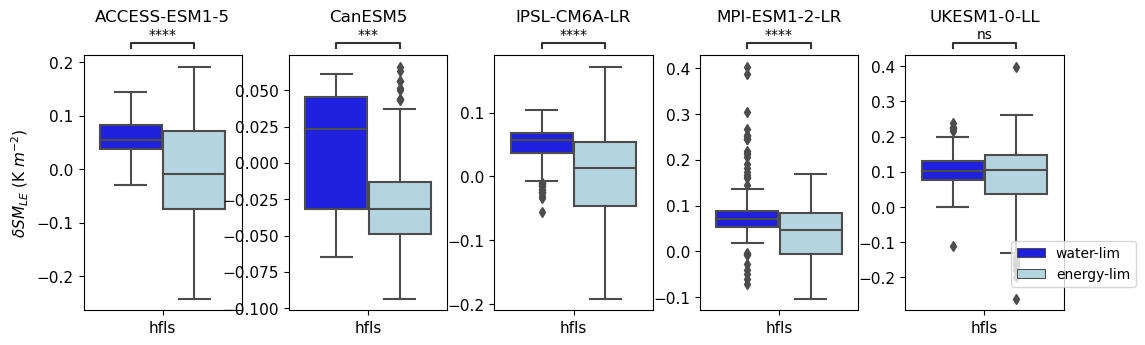

In [188]:
from statannot import add_stat_annotation
import seaborn.categorical


width_inch = 14
height_inch = 3

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(1, 5)
    
for m, mm in enumerate(models):
        df = coef_pos_SM[m]
    
        axs = fig.add_subplot(gs[0, m])
        axs = sns.boxplot(data=df, x='variable', y='value', hue='regime', palette=['blue', 'lightblue'])

        axs.legend_.remove()
        axs.set_xlabel("")
        axs.tick_params(labelsize=11)
        axs.set_title(models[m], y = 1.1)
        # axs.label_outer()
        if m == 0:
            axs.set_ylabel("$\delta SM_{LE}$ (K $m^{-2}$)", fontsize = 11)    
        else:
            axs.set_ylabel("")    
        if m == 4:
            axs.legend(loc='upper right', bbox_to_anchor=(1.5, 0.3) ,fontsize = 10)
        
        
        add_stat_annotation(axs, data=df, x='variable', y='value', hue='regime',
                        box_pairs=[(("hfls", "water-lim"), ("hfls", "energy-lim"))],
                        test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = "bonferroni", verbose=2)

# fig.tight_layout()
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
# fig.suptitle("Linear regression (dTs/dLAI)", y =1.2, x = 0.45)


## Estimate of dTs/dLE & dTs/dLAI

In [31]:
%%capture

from sklearn import linear_model
from regressors import stats

linear = linear_model.LinearRegression()
# linear = linear_model.Ridge()

dTs_LE = []
dTs_LE_pval = []

for m, mm in enumerate(models):
    data = (xr_aff[m] - xr_ctl[m])
    
    ## Preprocessing
    # Dimension time on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. 
    # To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.compute()`
    # Replace NaN and 0 with 0.01 to avoid Singular Matrix 

    # X1 = data.lai.resample(time='Y', label='left').mean().compute()

    X = data.ts.resample(time='Y', label='left').mean().compute()
    Y = data.hfls.resample(time='Y', label='left').mean().compute()
    
    # 1st order detrending
    X = detrend_dim(X, "time", 1)
    Y = detrend_dim(Y, "time", 1)
    
    ## Standardization
    X = (X - X.mean(dim = ["time"]))/X.std(dim = ["time"])
    
    # Gap filling
    X = X.fillna(0.001); X = X.where(X != 0, 0.001)
    Y = Y.fillna(0.001); Y = Y.where(Y != 0, 0.001)

    coef = lag_linregress_3D(Y,X)["coef"]
    pval = lag_linregress_3D(Y,X)["pval"]

    dTs_LE.append(coef)
    dTs_LE_pval.append(pval)

In [32]:
dTs_LAI = []

for m, mm in enumerate(models):
    coef = coef_reg[m].lai.transpose("lat","lon").data * dTs_LE[m]

    dTs_LAI.append(coef)

C:\Users\mastr\AppData\Local\Temp\ipykernel_16780\2570756359.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


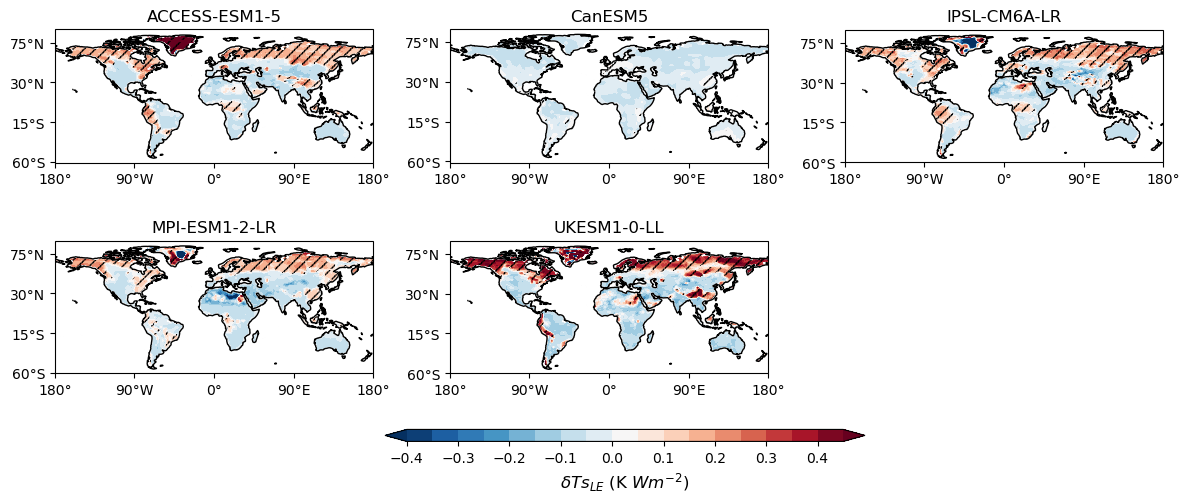

In [89]:
# luc_rate = luc_rate.sel(lat = slice(-60,90))
# luc_rate = luc_rate - luc_rate.isel(time = 0)

cmap = "RdBu_r"
clevs=np.arange(-0.4,0.5,0.05)

width_inch = 12
height_inch = 6

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()
for i in np.arange(len(models)):
    
    data = dTs_LE[i]
    lats = data.lat
    hatch = dTs_LE_pval[i]
    
    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=data['lon'])

    map = axs[i].contourf(lons, lats, data, clevs, transform = ccrs.PlateCarree(), cmap=cmap,extend='both')
    axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor="white"))
    axs[i].coastlines()
    
    sign = np.ma.masked_greater(hatch, 0.1)
    map1 = axs[i].pcolor(lons, lats, sign, hatch = '///', transform = ccrs.PlateCarree(), alpha=0)
    
    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
    # Set subplot title
    axs[i].set_title(models[i])
    
    # axs[i].label_outer()
    
for i in [5]:
    fig.delaxes(axs[i])
        

fig.subplots_adjust(bottom=0.2, top=2, left=0.1, right=0.8, wspace=0.0, hspace=0.2)

cb_ax = fig.add_axes([0.325, 0.1, 0.4, 0.02])
cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)  
cbar.ax.set_xlabel("$\delta Ts_{LE}$ (K $W m^{-2}$)", fontsize=12)

fig.tight_layout()

# title = "Ts_esm_mw_0.1"
# output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

C:\Users\mastr\AppData\Local\Temp\ipykernel_16780\3648446761.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


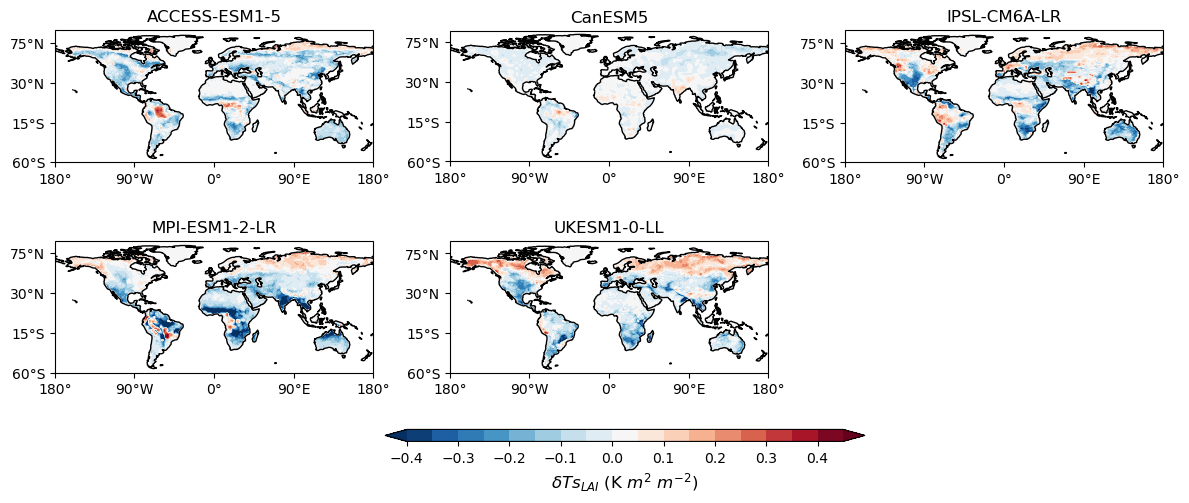

In [41]:
# luc_rate = luc_rate.sel(lat = slice(-60,90))
# luc_rate = luc_rate - luc_rate.isel(time = 0)

cmap = "RdBu_r"
clevs=np.arange(-0.4,0.5,0.05)

width_inch = 12
height_inch = 6

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()
for i in np.arange(len(models)):
    
    data = dTs_LAI[i]
    lats = data.lat
    # hatch = xr_mw_ts[i]
    
    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=data['lon'])

    map = axs[i].contourf(lons, lats, data, clevs, transform = ccrs.PlateCarree(), cmap=cmap,extend='both')
    axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor="white"))
    axs[i].coastlines()
    
    # sign = np.ma.masked_greater(hatch, 0.1)
    # map1 = axs[i].pcolor(lons, lats, sign, hatch = '///', transform = ccrs.PlateCarree(), alpha=0)
    
    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
    # Set subplot title
    axs[i].set_title(models[i])
    
    # axs[i].label_outer()
    
for i in [5]:
    fig.delaxes(axs[i])
        

fig.subplots_adjust(bottom=0.2, top=2, left=0.1, right=0.8, wspace=0.0, hspace=0.2)

cb_ax = fig.add_axes([0.325, 0.1, 0.4, 0.02])
cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)  
cbar.ax.set_xlabel("$\delta Ts_{LAI}$ (K $m^{2}$ $m^{-2}$)", fontsize=12)

fig.tight_layout()

# title = "Ts_esm_mw_0.1"
# output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

### Masking water & energy limited regions

In [42]:
dTs_LAI_pos_water = []
dTs_LAI_pos_energy = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    content = (dTs_LAI[m].where(mask_treefrac_pos[m].notnull()).where(mask_aff_water[m].notnull())
                              .stack(cell=["lon", "lat"])).dropna(dim='cell').to_dataframe(name = "lai").drop(columns = ["lon", "lat","height"]) #.dropna()
    content1 = (dTs_LAI[m].where(mask_treefrac_pos[m].notnull()).where(mask_aff_energy[m].notnull())
                              .stack(cell=["lon", "lat"])).dropna(dim='cell').to_dataframe(name = "lai").drop(columns = ["lon", "lat","height"]) #.dropna()
    if hasattr(content, "type"):
        content = content.drop(columns = ["type"])
        content1 = content1.drop(columns = ["type"])
    if hasattr(content, "time"):
        content = content.drop(columns = ["time"])
        content1 = content1.drop(columns = ["time"])
    dTs_LAI_pos_water.append(content.reset_index())
    dTs_LAI_pos_energy.append(content1.reset_index())
    
    # dTs_LAI_pos_water[m]['coef'] = dTs_LAI_pos_water[m]['coef'].map(mapping)
    # dTs_LAI_pos_energy[m]['coef'] = dTs_LAI_pos_energy[m]['coef'].map(mapping)

In [43]:
dTs_LAI_pos = []
for m,mm in enumerate(models):
    a = pd.melt(dTs_LAI_pos_water[m].drop(columns = ["lon", "lat"])); a["regime"] = "water-lim"
    b = pd.melt(dTs_LAI_pos_energy[m].drop(columns = ["lon", "lat"])); b["regime"] = "energy-lim"
    dTs_LAI_pos.append(pd.concat([a,b], axis = 0))
del a, b

In [161]:
value = 0
for m, mm in enumerate(models):
    value = np.append(value, np.mean(dTs_LAI_pos[m].value).round(3))
    print("Median dTS_dLAI for "+mm +": "+ str(np.median(dTs_LAI_pos[m].value).round(3)))

    print("Median dTS_dLAI for "+mm +" in water-lim regions: "+ str(np.mean(dTs_LAI_pos[m][dTs_LAI_pos[m]["regime"] == "water-lim"].value).round(3))
            + " +- "+ str(np.array(np.std(dTs_LAI_pos[m][dTs_LAI_pos[m]["regime"] == "water-lim"].value)).round(3)))

value = np.delete(value, 0)
print("MM Mean dTS_dLAI: " + str(np.mean(value).round(3)) + " +- "+ str(np.std(value).round(3)))

Median dTS_dLAI for ACCESS-ESM1-5: -0.022
Median dTS_dLAI for ACCESS-ESM1-5 in water-lim regions: -0.036 +- 0.128
Median dTS_dLAI for CanESM5: 0.003
Median dTS_dLAI for CanESM5 in water-lim regions: -0.024 +- 0.054
Median dTS_dLAI for IPSL-CM6A-LR: -0.046
Median dTS_dLAI for IPSL-CM6A-LR in water-lim regions: -0.138 +- 0.153
Median dTS_dLAI for MPI-ESM1-2-LR: -0.119
Median dTS_dLAI for MPI-ESM1-2-LR in water-lim regions: -0.246 +- 0.202
Median dTS_dLAI for UKESM1-0-LL: -0.068
Median dTS_dLAI for UKESM1-0-LL in water-lim regions: -0.129 +- 0.11
MM Mean dTS_dLAI: -0.073 +- 0.063


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

lai_water-lim v.s. lai_energy-lim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.862e-01 U_stat=3.191e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

lai_water-lim v.s. lai_energy-lim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.751e-03 U_stat=8.300e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

lai_water-lim v.s. lai_energy-lim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.481e-29 U_stat=1.073e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e

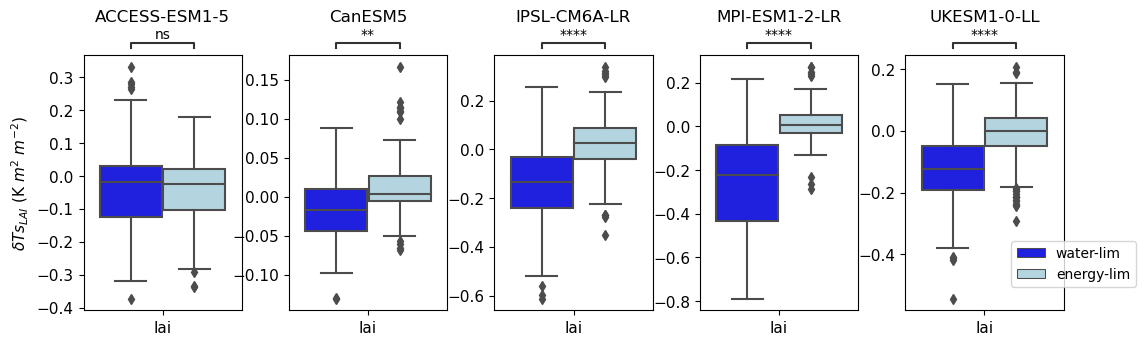

In [63]:
from statannot import add_stat_annotation
import seaborn.categorical


width_inch = 14
height_inch = 3

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(1, 5)
    
for m, mm in enumerate(models):
        df = dTs_LAI_pos[m]
    
        axs = fig.add_subplot(gs[0, m])
        axs = sns.boxplot(data=df, x='variable', y='value', hue='regime', palette=['blue', 'lightblue'])

        axs.legend_.remove()
        axs.set_xlabel("")
        axs.tick_params(labelsize=11)
        axs.set_title(models[m], y = 1.1)
        # axs.label_outer()
        if m == 0:
            axs.set_ylabel("$\delta Ts_{LAI}$ (K $m^{2}$ $m^{-2}$)", fontsize = 11)    
        else:
            axs.set_ylabel("")    
        if m == 4:
            axs.legend(loc='upper right', bbox_to_anchor=(1.5, 0.3) ,fontsize = 10)
        
        
        add_stat_annotation(axs, data=df, x='variable', y='value', hue='regime',
                        box_pairs=[(("lai", "water-lim"), ("lai", "energy-lim"))],
                        test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = "bonferroni", verbose=2)

# fig.tight_layout()
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
# fig.suptitle("Linear regression (dTs/dLAI)", y =1.2, x = 0.45)
